In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
import numpy as np
import tensorflow as tf
import h5py

from src.DataPreprocessor.data_preprocessor import DataPreprocessor, Mode
from src.LearningKeras.net_architecture import cnn_150x150x5, cnn_150x150x5_3class
from src.LearningKeras.train import KerasTrainer

from tqdm import trange

np.random.seed(1)
tf.set_random_seed(2)

check data_visualisation for details

In [2]:
from src.DataPreprocessor.DataIOBackend.gdal_backend import GdalBackend
from src.DataPreprocessor.data_visualiser import DataVisualiser

dataiobackend = GdalBackend()
data_preprocessor = DataPreprocessor(data_dir="data/Region 1 - Lopukangri/",
                              backend=dataiobackend,
                              filename_prefix="tibet",
                              mode=Mode.TRAIN,
                              seed=1)

check training for details

In [3]:
model_generator = lambda: cnn_150x150x5()
ensemble_size = 5
batch_size = 5

trainer = KerasTrainer(model_generator=model_generator,
                       ensemble_size=ensemble_size,
                       data_preprocessor=data_preprocessor,
                       batch_size=batch_size)

In [4]:
boxes, avg_fault_probs = trainer.apply_for_sliding_window(data_preprocessor, stride=50)

100%|██████████| 3969/3969 [13:31<00:00,  4.89it/s]


In [13]:

with h5py.File('predicting_tmp.h5', 'w') as hf:
    hf.create_dataset("dataset",  data=np.array(boxes))

In [14]:
with h5py.File('predicting_tmp2.h5', 'w') as hf:
    hf.create_dataset("dataset",  data=np.array(avg_fault_probs))

In [4]:
with h5py.File('predicting_tmp.h5', 'r') as hf:
    boxes = hf['dataset'][:]
with h5py.File('predicting_tmp2.h5', 'r') as hf:
    avg_fault_probs = hf['dataset'][:]

In [18]:
res_max_supp = trainer.apply_for_sliding_window_non_max_suppression(boxes, avg_fault_probs, 50, data_preprocessor)

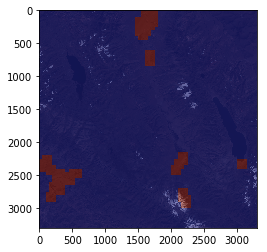

In [22]:
plt.imshow(np.array(res_max_supp))
plt.show()

In [20]:
res_max_supp.save('sliding_window_max_supp.tif')

In [5]:
res = trainer.apply_for_sliding_window_heatmaps(boxes, avg_fault_probs, data_preprocessor)

100%|██████████| 3969/3969 [00:00<00:00, 7587.85it/s]


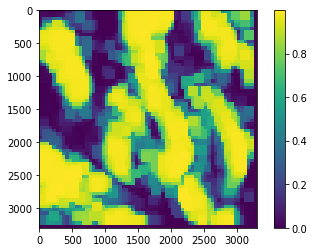

In [7]:
plt.imshow(np.array(res))
plt.colorbar()
plt.show()

In [23]:
cmap = plt.get_cmap('jet')
rgba_img = cmap(res)
rgb_img = np.delete(rgba_img, 3, 2)

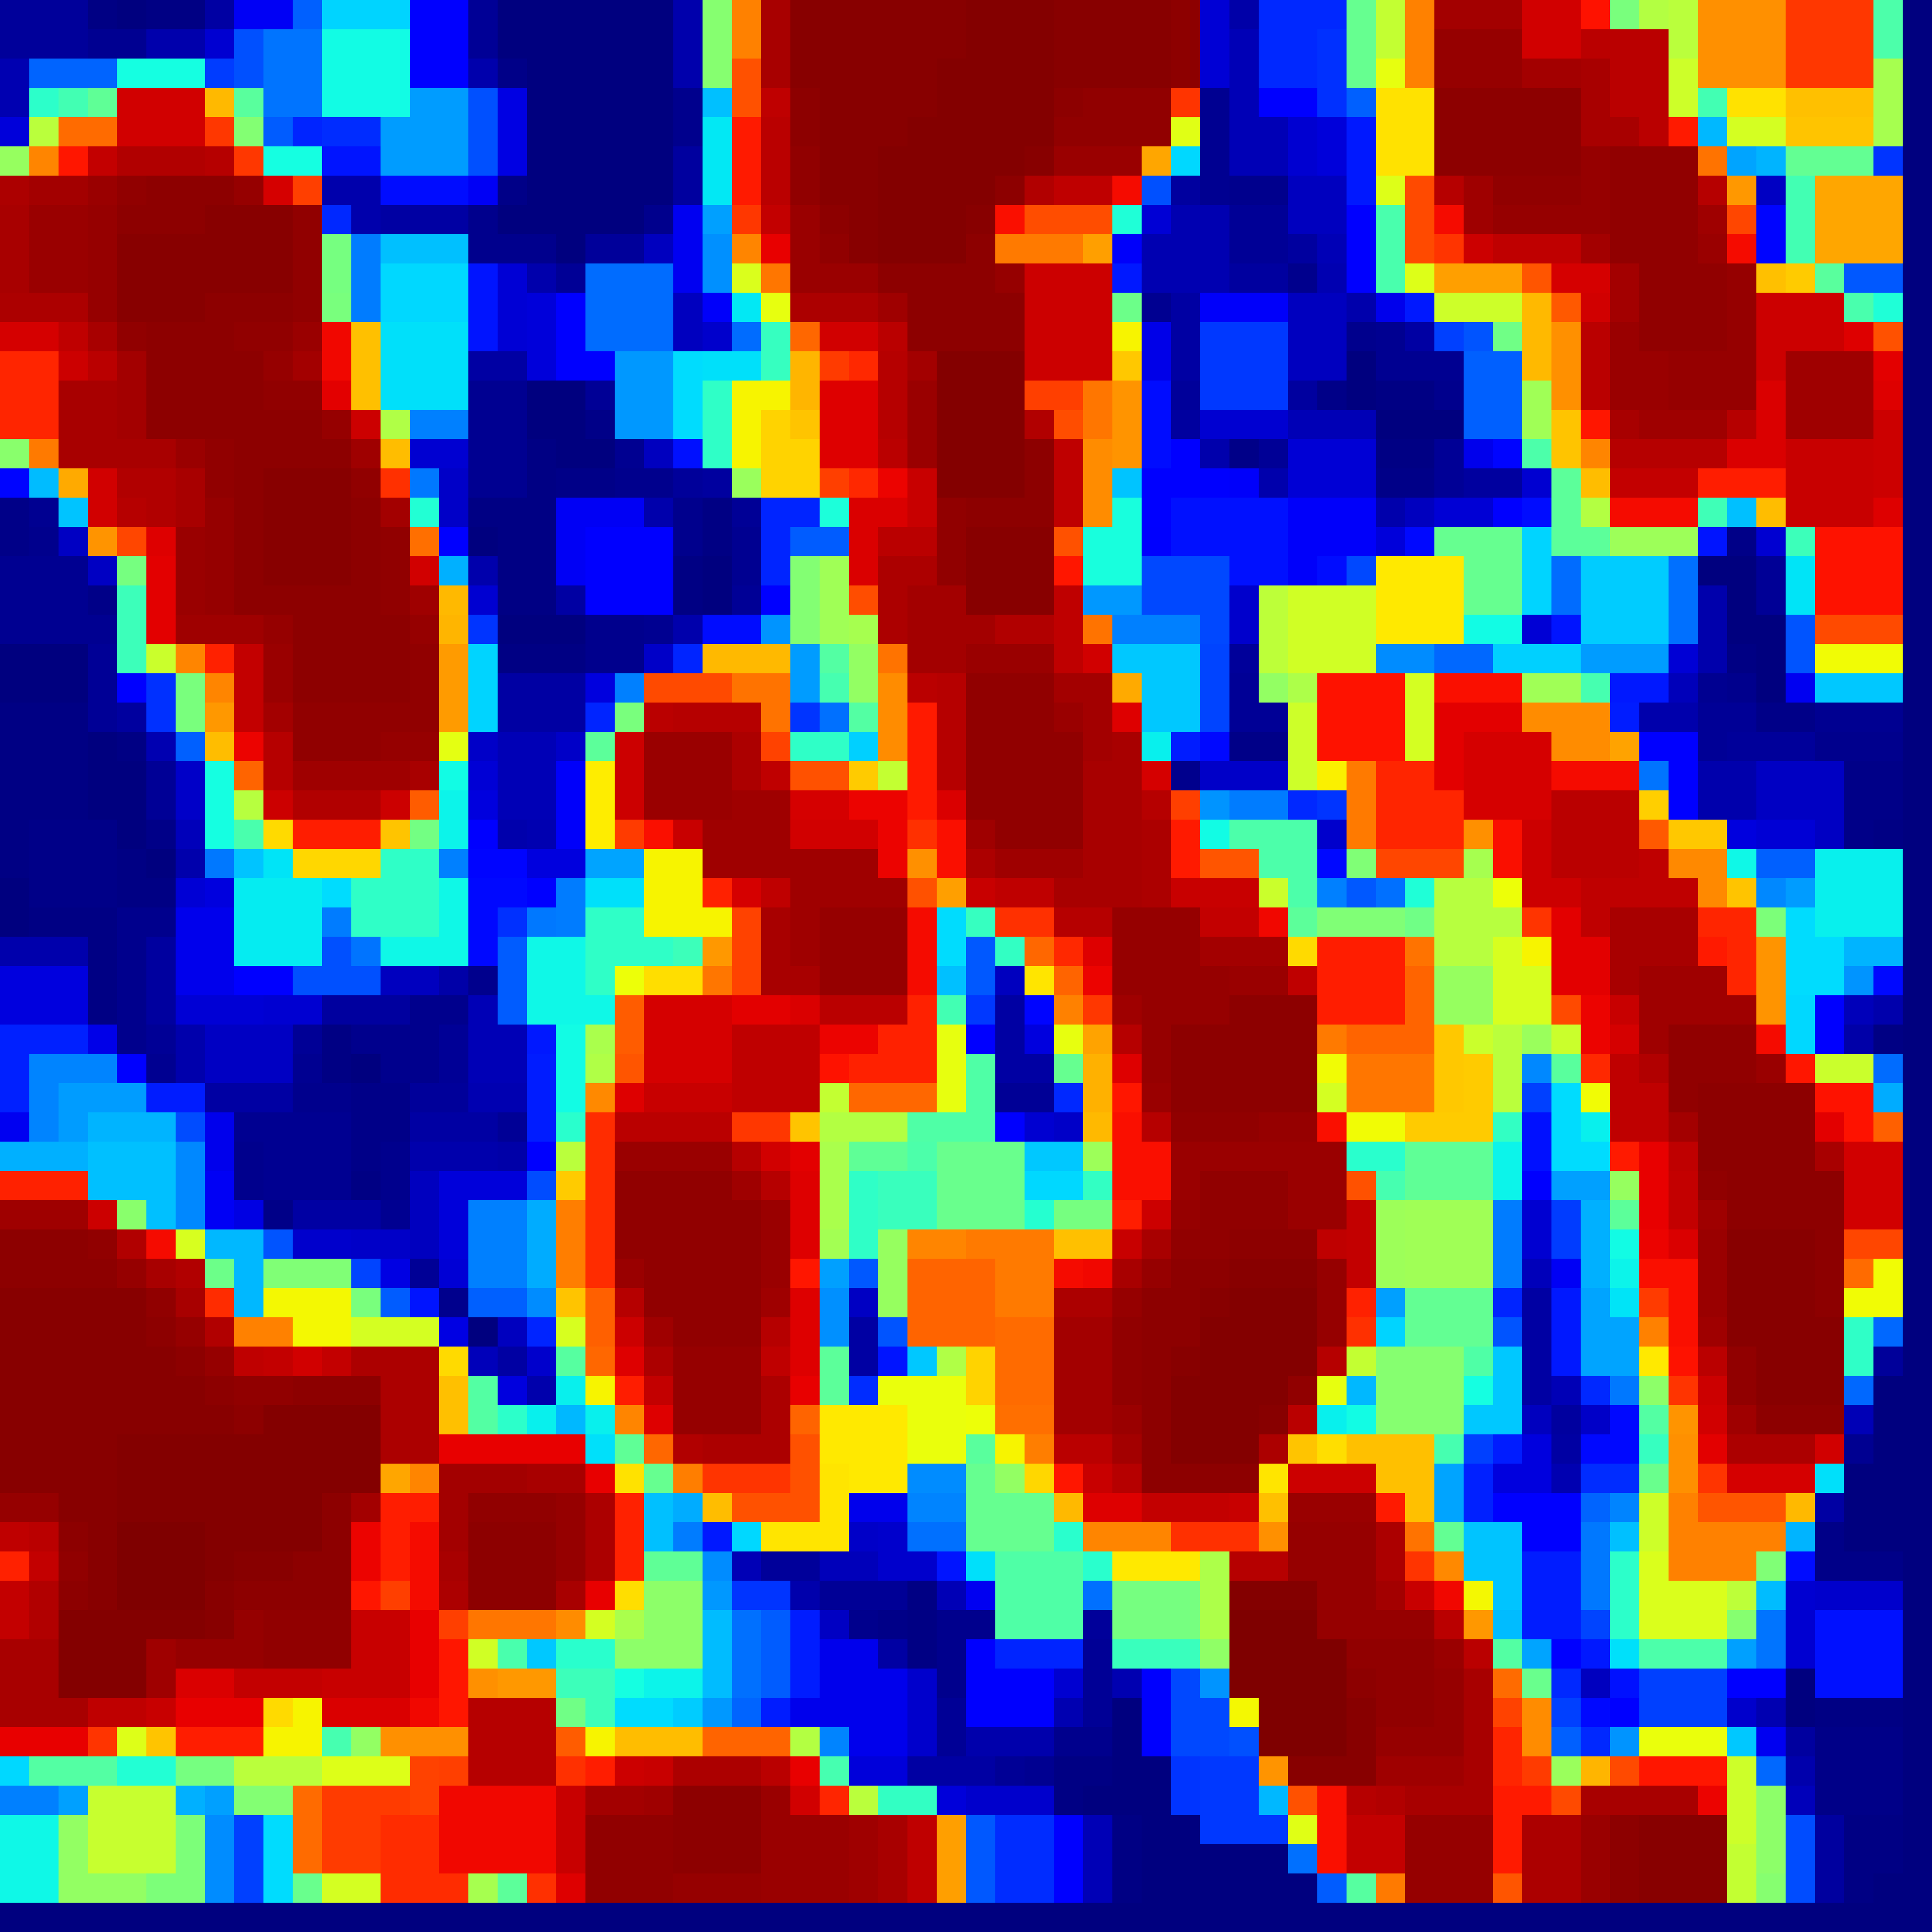

In [29]:
res_im=(rgba_img[:, :, :3] * 255).astype(np.uint8)
Image.fromarray(res_im)

In [34]:
dataiobackend.write_image("heatmaps_3_colours.tif", res_im)

0

### 3-class

In [3]:
model_generator = lambda: cnn_150x150x5_3class()
ensemble_size = 2
batch_size = 5

trainer = KerasTrainer(model_generator=model_generator,
                       ensemble_size=ensemble_size,
                       data_preprocessor=data_preprocessor,
                       batch_size=batch_size)

In [5]:
boxes, avg_fault_probs, avg_lookalike_probs, avg_non_fault_probs = trainer.apply_for_sliding_window_3class_batch(data_preprocessor, stride=50, batch_size=20)

100%|██████████| 198/198 [01:08<00:00,  2.87it/s]


In [6]:
res_faults = trainer.apply_for_sliding_window_heatmaps(boxes, avg_fault_probs, data_preprocessor)

100%|██████████| 3969/3969 [00:00<00:00, 8522.17it/s]


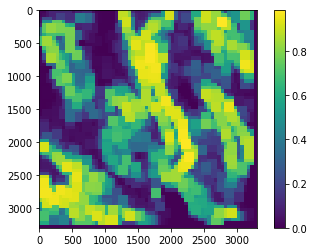

In [7]:
plt.imshow(np.array(res_faults))
plt.colorbar()
plt.show()

In [8]:
cmap = plt.get_cmap('jet')
rgba_img_faults = cmap(res_faults)
rgb_img_faults = np.delete(rgba_img_faults, 3, 2)
rgb_img_faults=(rgb_img_faults[:, :, :3] * 255).astype(np.uint8)

In [9]:
dataiobackend.write_image("heatmaps_3class_faults.tif", rgb_img_faults)

In [10]:
res_lookalikes = trainer.apply_for_sliding_window_heatmaps(boxes, avg_lookalike_probs, data_preprocessor)

100%|██████████| 3969/3969 [00:00<00:00, 9457.79it/s]


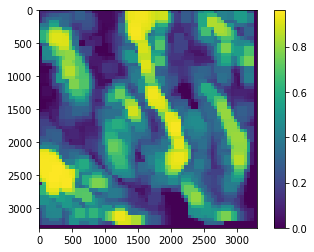

In [11]:
plt.imshow(np.array(res_lookalikes))
plt.colorbar()
plt.show()

In [12]:
cmap = plt.get_cmap('jet')
rgba_img_lookalikes = cmap(res_lookalikes)
rgb_img_lookalikes = np.delete(rgba_img_lookalikes, 3, 2)
rgb_img_lookalikes=(rgb_img_lookalikes[:, :, :3] * 255).astype(np.uint8)
dataiobackend.write_image("heatmaps_3class_lookalikes.tif", rgb_img_lookalikes)